In [1]:
import glob
import os

import mudata as mu
import pandas as pd
import tqdm

import deconvatac as de
import scipy.stats as stats

import seaborn as sns
import matplotlib.pyplot as plt


/vol/storage/miniconda3/envs/atac2space/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/vol/storage/miniconda3/envs/atac2space/lib/python3.11/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/vol/storage/miniconda3/envs/atac2space/lib/python3.11/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (


In [2]:
data_path = "/vol/storage/submission_data"

## Create Results Table

In [24]:
def get_proportions(adata):
    df = pd.DataFrame(adata.obsm["proportions"], columns=adata.uns["proportion_names"], index=adata.obs_names)
    return df

In [25]:
methods = ["tangram", "rctd", "spatialdwls", "destvi", "cell2location"]
modalities = ["atac", "rna"]
# go over all methods and modalities
df = [pd.DataFrame({'path': glob.glob(os.path.join(data_path, "deconvolution_results", method, modality, "*", "*"))}) for method in methods for modality in modalities]
df = pd.concat(df)
df[['method', 'modality', 'dataset_features']] = df['path'].str.split('/', expand=True).iloc[:, 5:-1]
df['dataset'] = df['dataset_features'].str.rsplit("_", n=2).str[0]
df["features"] = df["dataset_features"].str.split("_", n=2).str[-1]

In [26]:
df

,path,method,modality,dataset_features,dataset,features
0,/vol/storage/submission_data/deconvolution_res...,tangram,atac,Brain_1_highly_accessible,Brain_1,highly_accessible
1,/vol/storage/submission_data/deconvolution_res...,tangram,atac,Heart_3_highly_accessible,Heart_3,highly_accessible
2,/vol/storage/submission_data/deconvolution_res...,tangram,atac,russell_250_highly_variable,russell_250,highly_variable
3,/vol/storage/submission_data/deconvolution_res...,tangram,atac,Brain_2_highly_variable,Brain_2,highly_variable
4,/vol/storage/submission_data/deconvolution_res...,tangram,atac,russell_250_highly_accessible,russell_250,highly_accessible
...,...,...,...,...,...,...
13,/vol/storage/submission_data/deconvolution_res...,cell2location,rna,Heart_2_highly_variable,Heart_2,highly_variable
14,/vol/storage/submission_data/deconvolution_res...,cell2location,rna,Heart_1_highly_variable,Heart_1,highly_variable
15,/vol/storage/submission_data/deconvolution_res...,cell2location,rna,Heart_1_highly_variable,Heart_1,highly_variable
16,/vol/storage/submission_data/deconvolution_res...,cell2location,rna,Brain_4_highly_variable,Brain_4,highly_variable


In [27]:
mapping_dict = {
    "russell_250": os.path.join(data_path, "data/simulations/russell_250.h5mu"),
    "Heart_1": os.path.join(data_path, "data/simulations/Heart_1.h5mu"),
    "Heart_2": os.path.join(data_path, "data/simulations/Heart_2.h5mu"),
    "Heart_3": os.path.join(data_path, "data/simulations/Heart_3.h5mu"),
    "Heart_4": os.path.join(data_path, "data/simulations/Heart_4.h5mu"),
    "Brain_1": os.path.join(data_path, "data/simulations/Brain_1.h5mu"),
    "Brain_2": os.path.join(data_path, "data/simulations/Brain_2.h5mu"),
    "Brain_3": os.path.join(data_path, "data/simulations/Brain_3.h5mu"),
    "Brain_4": os.path.join(data_path, "data/simulations/Brain_4.h5mu"),
}

In [28]:
df["mdata_spatial_path"] = df['dataset'].map(mapping_dict)

In [29]:
def load_table(path, index_col):
    """
    Load results CSV file and convert to probabilties.

    Parameters
    ----------
    path (str): The path to the CSV file.
    index_col (int or None): Column to set as index (None if no index column).

    Returns
    -------
    pandas.DataFrame.
    """
    res = pd.read_csv(path, index_col=index_col)
    if "q05cell_abundance_w_sf_" in res.columns[0]:
        res.columns = res.columns.to_series().str.split("q05cell_abundance_w_sf_", expand=True).loc[:, 1].values
    elif "meanscell_abundance_w_sf_" in res.columns[0]:
        res.columns = res.columns.to_series().str.split("meanscell_abundance_w_sf_", expand=True).loc[:, 1].values
    if res.index[0] != 0:
        res.index = res.index.astype(int) - 1
    res.index = res.index.astype(str)
    if "cell_ID" in res.columns:
        res.drop("cell_ID", axis=1, inplace=True)
    res = res.div(res.sum(axis=1), axis=0)
    return res

In [30]:
jsd = []
rmse = []
for _, row in tqdm.tqdm(df.iterrows()):
    # load ground truth
    target_adata = mu.read(row["mdata_spatial_path"])
    targets = get_proportions(target_adata[row["modality"]])

    # load table
    predictions = load_table(row["path"], index_col=(None if row["method"] == "moscot" else 0))
    predictions = predictions.loc[targets.index, targets.columns]
    jsd.append(de.tl.jsd(predictions, targets))
    rmse.append(de.tl.rmse(predictions, targets))
df["jsd"] = jsd
df["rmse"] = rmse

0it [00:00, ?it/s]/vol/storage/miniconda3/envs/atac2space/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/vol/storage/miniconda3/envs/atac2space/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
1it [00:21, 21.48s/it]/vol/storage/miniconda3/envs/atac2space/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/vol/storage/miniconda3/envs/atac2space/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
2it [00:28, 12.86s/it]/vol/storage/miniconda3/envs/atac2space/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated

In [ ]:
df = df.replace({"tangram": "tangram cell mode"})

In [48]:
df["Type"] = df.dataset.apply(
    lambda x: "Simulation dissociated data" if ("Brain" in x or "Heart" in x) else "Simulation targeted data"
)

In [14]:
df_tangram = pd.read_csv("tables/results_table_tangram_cluster_mode.csv", index_col=0)

In [16]:
df_tangram = df_tangram.replace({"tangram": "tangram cluster mode"})
df_tangram["Type"] = df_tangram.dataset.apply(
    lambda x: "Simulation dissociated data" if ("Brain" in x or "Heart" in x) else "Simulation targeted data"
)

In [ ]:
df.to_csv("tables/results_table.csv")

In [17]:
df_tangram.to_csv("tables/results_table_tangram_cluster_mode.csv")

## Add baselines

In [49]:
df_baseline = pd.DataFrame(
            {
                "dataset": df.drop_duplicates("dataset")["dataset"].values,
                "mdata_spatial_path": df.drop_duplicates("dataset")["mdata_spatial_path"].values,
                "method": "baseline majority cell type",
            })

In [50]:
df_baseline

,dataset,mdata_spatial_path,method
0,Brain_1,/vol/storage/submission_data/data/simulations/...,baseline majority cell type
1,Heart_3,/vol/storage/submission_data/data/simulations/...,baseline majority cell type
2,russell_250,/vol/storage/submission_data/data/simulations/...,baseline majority cell type
3,Brain_2,/vol/storage/submission_data/data/simulations/...,baseline majority cell type
4,Brain_4,/vol/storage/submission_data/data/simulations/...,baseline majority cell type
5,Brain_3,/vol/storage/submission_data/data/simulations/...,baseline majority cell type
6,Heart_1,/vol/storage/submission_data/data/simulations/...,baseline majority cell type
7,Heart_4,/vol/storage/submission_data/data/simulations/...,baseline majority cell type
8,Heart_2,/vol/storage/submission_data/data/simulations/...,baseline majority cell type


In [51]:
jsd = []
rmse = []
for _, row in tqdm.tqdm(df_baseline.iterrows()):
    # load ground truth
    target_adata = mu.read(row["mdata_spatial_path"])
    targets = get_proportions(target_adata["atac"])

    # load table and get majority cell type
    predictions = pd.DataFrame(0, index=targets.index, columns=targets.columns)
    for index, row in targets.iterrows():
        max_index = row.idxmax()
        predictions.loc[index, max_index] = 1

    jsd.append(de.tl.jsd(predictions, targets))
    rmse.append(de.tl.rmse(predictions, targets))
df_baseline["jsd"] = jsd
df_baseline["rmse"] = rmse

0it [00:00, ?it/s]/vol/storage/miniconda3/envs/atac2space/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/vol/storage/miniconda3/envs/atac2space/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
1it [00:01,  1.84s/it]/vol/storage/miniconda3/envs/atac2space/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/vol/storage/miniconda3/envs/atac2space/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
2it [00:52, 30.40s/it]/vol/storage/miniconda3/envs/atac2space/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated

In [52]:
df_baseline["Type"] = df_baseline.dataset.apply(
    lambda x: "Simulation dissociated data" if 
    ("Brain" in x or "Heart" in x) else "Simulation targeted data"
)

In [53]:
df_baseline.groupby(
    [
        "Type",
        "method",
    ]
)[["jsd", "rmse"]].mean()

,,jsd,rmse
Type,method,,
Simulation dissociated data,baseline majority cell type,0.627964,0.200405
Simulation targeted data,baseline majority cell type,0.442238,0.176135


In [54]:
df_baseline.to_csv("tables/baseline_results.csv")

## Create table

In [3]:
df = pd.read_csv('tables/results_table.csv', index_col=0)

In [4]:
df_tangram = pd.read_csv("tables/results_table_tangram_cluster_mode.csv", index_col=0)

In [5]:
df = pd.concat([df, df_tangram])

In [6]:
agg_funcs = {"jsd": ["mean", "std"], "rmse": ["mean", "std"]}

In [7]:
summarized_table = df.groupby(["Type", "method", "features", "modality"]).agg(agg_funcs).melt(
    ignore_index=False, var_name=["metric", "measure"], value_name="score"
).pivot_table(index=["method"], columns=["Type", "metric", "modality", "features", "measure"], values="score")

In [8]:
summarized_table

Type                 Simulation dissociated data                            \
metric                                       jsd                             
modality                                    atac                             
features                       highly_accessible           highly_variable   
measure                                     mean       std            mean   
method                                                                       
cell2location                           0.342254  0.020802        0.332170   
destvi                                  0.636453  0.107408        0.500267   
rctd                                    0.373164  0.022039        0.334259   
spatialdwls                             0.606853  0.097540        0.480909   
tangram cell mode                       0.668890  0.120272        0.663686   
tangram cluster mode                    0.708202  0.110879        0.671444   

Type                                                                        \
metric                                                                rmse   
modality                                   rna                        atac   
features                       highly_variable           highly_accessible   
measure                    std            mean       std              mean   
method                                                                       
cell2location         0.021045        0.249306  0.032384          0.081412   
destvi                0.124946        0.363021  0.041271          0.137069   
rctd                  0.022932        0.267343  0.037627          0.088742   
spatialdwls           0.083714        0.366956  0.108687          0.151772   
tangram cell mode     0.120588        0.650571  0.115226          0.145290   
tangram cluster mode  0.117298        0.564778  0.133498          0.167481   

Type                                                      ...  \
metric                                                    ...   
modality                                                  ...   
features                       highly_variable            ...   
measure                    std            mean       std  ...   
method                                                    ...   
cell2location         0.011909        0.081388  0.012944  ...   
destvi                0.032511        0.106553  0.021048  ...   
rctd                  0.012820        0.084539  0.011243  ...   
spatialdwls           0.014578        0.122300  0.011526  ...   
tangram cell mode     0.040938        0.144768  0.041002  ...   
tangram cluster mode  0.041094        0.153898  0.041434  ...   

Type                 Simulation targeted data                            \
metric                                    jsd                             
modality                                 atac                       rna   
features                      highly_variable           highly_variable   
measure                                  mean       std            mean   
method                                                                    
cell2location                        0.238432  0.015109        0.207473   
destvi                               0.733979       NaN        0.718773   
rctd                                 0.287798       NaN        0.272234   
spatialdwls                          0.500152       NaN        0.276993   
tangram cell mode                    0.205098       NaN        0.172017   
tangram cluster mode                 0.494151       NaN        0.462513   

Type                                                                        \
metric                                      rmse                             
modality                                    atac                             
features                       highly_accessible           highly_variable   
measure                    std              mean       std            mean   
method                                                

In [9]:
# Rank based on mean of highly variable features
for i, type_ in enumerate(["Simulation dissociated data", "Simulation targeted data"]):
    jsd_values = summarized_table.loc[
        :, (type_, "jsd", "atac", "highly_variable", "mean")
    ]
    rmse_values = summarized_table.loc[
        :, (type_, "rmse", "atac", "highly_variable", "mean")
        ]
    summarized_table[f"Rank {i}"] = ((jsd_values + rmse_values) / 2).rank()

In [10]:
summarized_table['Overall Rank'] = summarized_table[[f"Rank {i}" for i in range(2)]].mean(axis=1).rank()

In [11]:
summarized_table = summarized_table.sort_values("Overall Rank")

In [13]:
summarized_table = summarized_table.dropna(axis=1)

In [15]:
summarized_table.to_parquet("tables/summarized_results.pq")

In [16]:
summarized_table.to_excel("tables/summarized_results.xlsx")

In [76]:
## Drop highly accessible for figure and overall column

In [39]:
summarized_table_all = pd.read_parquet("tables/summarized_results.pq")

In [48]:
summarized_table_all = summarized_table_all.drop("highly_accessible", level="features", axis=1).dropna(axis=1).drop("tangram cluster mode")

In [39]:
summarized_table_all = summarized_table_all.round(3).astype(str).replace("0\\.", ".", regex=True)

In [40]:
summarized_table_all

Type              Simulation dissociated data                              \
metric                                    jsd                               
modality                                 atac                   rna         
features                      highly_variable       highly_variable         
measure                                  mean   std            mean   std   
method                                                                      
cell2location                            .332  .021            .249  .032   
rctd                                     .334  .023            .267  .038   
tangram cell mode                        .664  .121            .651  .115   
spatialdwls                              .481  .084            .367  .109   
destvi                                     .5  .125            .363  .041   

Type                                                           \
metric                       rmse                               
modality                     atac                   rna         
features          highly_variable       highly_variable         
measure                      mean   std            mean   std   
method                                                          
cell2location                .081  .013            .061  .015   
rctd                         .085  .011            .076  .026   
tangram cell mode            .145  .041            .141   .04   
spatialdwls                  .122  .012            .099  .031   
destvi                       .107  .021            .085   .02   

Type              Simulation targeted data                                  \
metric                                 jsd                            rmse   
modality                              atac             rna            atac   
features                   highly_variable highly_variable highly_variable   
measure                               mean            mean            mean   
method                                                                       
cell2location                         .238            .207             .09   
rctd                                  .288            .272            .107   
tangram cell mode                     .205            .172            .078   
spatialdwls                             .5            .277             .19   
destvi                                .734            .719            .207   

Type                              Rank 0 Rank 1 Overall Rank  
metric                                                        
modality                      rna                             
features          highly_variable                             
measure                      mean                             
method                                                        
cell2location                .075    1.0    2.0          1.0  
rctd                         .107    2.0    3.0          2.0  
tangram cell mode            .059    5.0    1.0          3.0  
spatialdwls                   .11    3.0    4.0          4.0  
destvi                       .213    4.0    5.0          5.0

In [41]:
summarized_table = summarized_table_all.loc[:, ["Simulation dissociated data"]]

In [42]:
# 1. Identify the "mean" and "std" columns
mean_cols = summarized_table.columns[summarized_table.columns.get_level_values("measure") == "mean"]
std_cols = summarized_table.columns[summarized_table.columns.get_level_values("measure") == "std"]

# 2. Create a mapping from "mean" column to corresponding "std" column
mean_to_std = {}
for mean_col in mean_cols:
    # Construct a tuple representing the same column, but with 'std' instead of 'mean'
    std_col_values = list(mean_col)  # Convert tuple to list for modification
    std_col_values[-1] = "std"  # Replace the last element ('mean') with 'std'
    std_col = tuple(std_col_values)  # Convert back to tuple

    if std_col in std_cols:  # Check if the corresponding 'std' column exists
        mean_to_std[mean_col] = std_col


# 3. Create new combined columns
for mean_col, std_col in mean_to_std.items():
    # Extract all the column levels except for 'measure'
    new_col_values = list(mean_col)
    new_col_values[-1] = "Mean ± Std"  # Give new name
    new_col = tuple(new_col_values)
    # Format the mean and std values as strings, and combine them
    summarized_table[new_col] = summarized_table[mean_col].astype(str) + " ± " + summarized_table[std_col].astype(str)

# 4. Drop the original "mean" and "std" columns
cols_to_drop = list(mean_cols) + list(std_cols)
summarized_table = summarized_table.drop(columns=cols_to_drop)

In [44]:
summarized_table_all = pd.concat([summarized_table, summarized_table_all.loc[:, ["Simulation targeted data", "Rank 0", "Rank 1", "Overall Rank"]]], axis=1)

In [45]:
summarized_table_all

Type              Simulation dissociated data                                  \
metric                                    jsd                            rmse   
modality                                 atac             rna            atac   
features                      highly_variable highly_variable highly_variable   
measure                            Mean ± Std      Mean ± Std      Mean ± Std   
method                                                                          
cell2location                     .332 ± .021     .249 ± .032     .081 ± .013   
rctd                              .334 ± .023     .267 ± .038     .085 ± .011   
tangram cell mode                 .664 ± .121     .651 ± .115     .145 ± .041   
spatialdwls                       .481 ± .084     .367 ± .109     .122 ± .012   
destvi                              .5 ± .125     .363 ± .041     .107 ± .021   

Type                              Simulation targeted data                  \
metric                                                 jsd                   
modality                      rna                     atac             rna   
features          highly_variable          highly_variable highly_variable   
measure                Mean ± Std                     mean            mean   
method                                                                       
cell2location         .061 ± .015                     .238            .207   
rctd                  .076 ± .026                     .288            .272   
tangram cell mode      .141 ± .04                     .205            .172   
spatialdwls           .099 ± .031                       .5            .277   
destvi                 .085 ± .02                     .734            .719   

Type                                              Rank 0 Rank 1 Overall Rank  
metric                       rmse                                             
modality                     atac             rna                             
features          highly_variable highly_variable                             
measure                      mean            mean                             
method                                                                        
cell2location                 .09            .075    1.0    2.0          1.0  
rctd                         .107            .107    2.0    3.0          2.0  
tangram cell mode            .078            .059    5.0    1.0          3.0  
spatialdwls                   .19             .11    3.0    4.0          4.0  
destvi                       .207            .213    4.0    5.0          5.0

In [46]:
for i, row in summarized_table_all.T.iterrows():
    print(i)
    print('\n'.join(row.values))


('Simulation dissociated data', 'jsd', 'atac', 'highly_variable', 'Mean ± Std')
.332 ± .021
.334 ± .023
.664 ± .121
.481 ± .084
.5 ± .125
('Simulation dissociated data', 'jsd', 'rna', 'highly_variable', 'Mean ± Std')
.249 ± .032
.267 ± .038
.651 ± .115
.367 ± .109
.363 ± .041
('Simulation dissociated data', 'rmse', 'atac', 'highly_variable', 'Mean ± Std')
.081 ± .013
.085 ± .011
.145 ± .041
.122 ± .012
.107 ± .021
('Simulation dissociated data', 'rmse', 'rna', 'highly_variable', 'Mean ± Std')
.061 ± .015
.076 ± .026
.141 ± .04
.099 ± .031
.085 ± .02
('Simulation targeted data', 'jsd', 'atac', 'highly_variable', 'mean')
.238
.288
.205
.5
.734
('Simulation targeted data', 'jsd', 'rna', 'highly_variable', 'mean')
.207
.272
.172
.277
.719
('Simulation targeted data', 'rmse', 'atac', 'highly_variable', 'mean')
.09
.107
.078
.19
.207
('Simulation targeted data', 'rmse', 'rna', 'highly_variable', 'mean')
.075
.107
.059
.11
.213
('Rank 0', '', '', '', '')
1.0
2.0
5.0
3.0
4.0
('Rank 1', '', '',

## Do significance tests

In [50]:
df['jsd_rmse'] = df[['jsd', 'rmse']].mean(axis=1)

### Test highly variable vs. highly accessible

In [51]:
wilcoxon = df.query("modality=='atac'")[["jsd_rmse", "features", "dataset"]].pivot_table(
    index="dataset", columns="features", values="jsd_rmse", aggfunc="mean"
)
wilcoxon

features,highly_accessible,highly_variable
dataset,,
Brain_1,0.282384,0.271475
Brain_2,0.276647,0.258090
Brain_3,0.294998,0.279109
Brain_4,0.299137,0.272575
Heart_1,0.337851,0.289413
Heart_2,0.308645,0.267616
Heart_3,0.313591,0.273775
Heart_4,0.323792,0.264211
russell_250,0.241742,0.247186


In [54]:
stats.wilcoxon(wilcoxon["highly_variable"], wilcoxon["highly_accessible"])

WilcoxonResult(statistic=1.0, pvalue=0.0078125)

## Analyse variability of the results

In [4]:
df["n_cell_types"] = df["dataset"].map(
    {
        "Brain_1": "homogeneous",
        "Brain_2": "heterogeneous",
        "Brain_3": "heterogeneous",
        "Brain_4": "homogeneous",
        "Heart_1": "homogeneous",
        "Heart_2": "heterogeneous",
        "Heart_3": "heterogeneous",
        "Heart_4": "homogeneous",
    }
)

df["n_cells"] = df["dataset"].map(
    {
        "Brain_1": "few",
        "Brain_2": "many",
        "Brain_3": "both",
        "Brain_4": "both",
        "Heart_1": "few",
        "Heart_2": "many",
        "Heart_3": "both",
        "Heart_4": "both",
    }
)

df["zonation"] = df["dataset"].map(
    {
        "Brain_1": "1 zone",
        "Brain_2": "1 zone",
        "Brain_3": ">1 zone",
        "Brain_4": ">1 zone",
        "Heart_1": "1 zone",
        "Heart_2": "1 zone",
        "Heart_3": ">1 zone",
        "Heart_4": ">1 zone",
    }
)

In [5]:
df.method.unique()

array(['tangram cell mode', 'rctd', 'spatialdwls', 'destvi',
       'cell2location'], dtype=object)

In [6]:
method_maps = {
    "tangram cell mode": "Tangram\nCell mode",
      "rctd": "RCTD",
    "spatialdwls": "SpatialDWLS",
    "destvi": "DestVI",
    "cell2location": "Cell2location",
}

In [7]:
test = df.dropna().query(" modality=='atac'")

In [8]:
test["method"] = test["method"].map(method_maps)
test = test.dropna()

In [9]:
test["score"] = test[["jsd", "rmse"]].mean(axis=1)

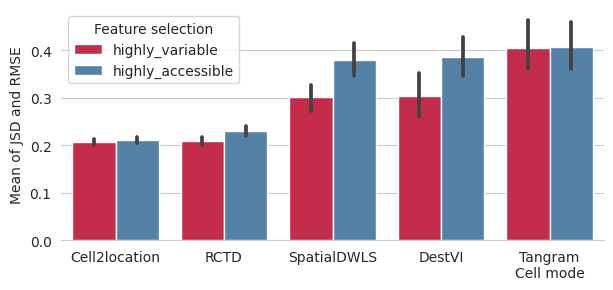

In [26]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(7, 3))
order = test.groupby("method")["score"].mean().sort_values().index
sns.barplot(
    data=test,
    x="method",
    y="score",
    hue="features",
    palette=["crimson", "steelblue"],
    order=order,
    hue_order=["highly_variable", "highly_accessible"],
    ax=ax,
)
sns.despine(left=True)
ax.set_ylabel("Mean of JSD and RMSE")
ax.set_xlabel("")
# move legend outside
plt.legend(title="Feature selection", loc="upper left")

In [10]:
test = test.query("features == 'highly_variable'")

In [18]:
df_excel = test.groupby(["method", "n_cell_types"]).score.agg({'mean', 'std'})

In [20]:
df_excel.to_excel("tables/n_cell_types_results.xlsx")

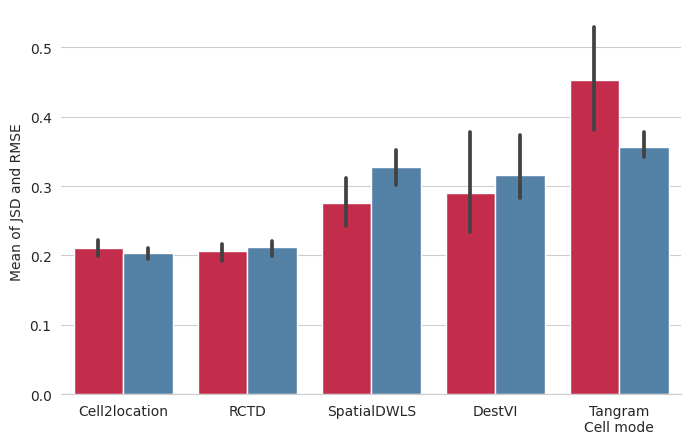

In [13]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(8, 5))
order = test.groupby("method")["score"].mean().sort_values().index
sns.barplot(data=test, x="method", y="score", hue="n_cell_types", palette=["crimson", "steelblue"], order=order, ax=ax, hue_order=["homogeneous", "heterogeneous"])
sns.despine(left=True)
ax.set_ylabel("Mean of JSD and RMSE")
ax.set_xlabel("")
# move legend outside
# plt.legend(title="Number of cell types", loc="upper left")
ax.legend_.remove()
# fig.savefig("../analysis/figures/Figure2/figure2b.png", dpi=300, bbox_inches="tight")

In [21]:
df_excel = test.groupby(["method", "zonation"]).score.agg({"mean", "std"})
df_excel.to_excel("tables/zonation_results.xlsx")

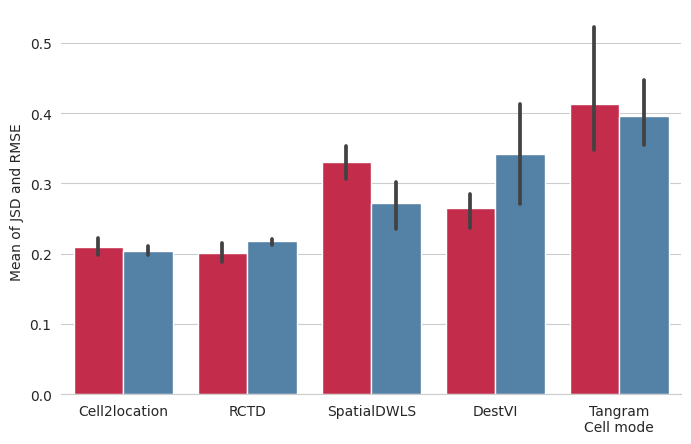

In [34]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(8, 5))
order = test.groupby("method")["score"].mean().sort_values().index
res = sns.barplot(
    data=test,
    x="method",
    y="score",
    hue="zonation",
    palette=["crimson", "steelblue"],
    order=order,
    ax=ax,
)
sns.despine(left=True)
ax.set_ylabel("Mean of JSD and RMSE")
ax.set_xlabel("")
# move legend outside
plt.legend(title="Zonation", loc="upper left")
ax.legend_.remove()
fig.savefig("../analysis/figures/Figure2/figure2c.png", dpi=300, bbox_inches="tight")